In [24]:
import keras
from keras.layers import Input, Conv2D, Flatten, MaxPool2D, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from keras import models
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np
import cv2
import time
import glob, os 
from skimage import io, transform

# Problem 1

Choose a small (< 3,000) image dataset for classification. Include the link where you have downloaded the pictures from.

---

In order for this to work, you need a kaggle account. With this, you can download the data set here [here](https://www.kaggle.com/ivanfel/honey-bee-pollen).

With this, we can read in the data at the path `/images`. This is where you must place the dataset after you download it.

In [3]:
path="images/"
imlist= glob.glob(os.path.join(path, '*.jpg'))

Now, we can read all the images, and shape them correctly. The function below reads all the images and returns the array and label for each corresponding label.

In [5]:
def dataset(file_list,size=(300,180),flattened=False):
    data = []
    for i, file in enumerate(file_list):
        image = io.imread(file)
        image = transform.resize(image, size, mode='constant')
        if flattened:
            image = image.flatten()

        data.append(image)

    labels = [1 if f.split("/")[-1][0] == 'P' else 0 for f in file_list]

    return np.array(data), np.array(labels)
X,Y=dataset(imlist)

With the images loaded and labeled, we can look at the shape of the data and target of the model.

In [12]:
print('Data:   ',X.shape)
print('Target: ',Y.shape)

Data:    (714, 300, 180, 3)
Target:  (714,)


Here, we see that we have 714 images that are RGB. 

Now lets look at an example from the dataset.

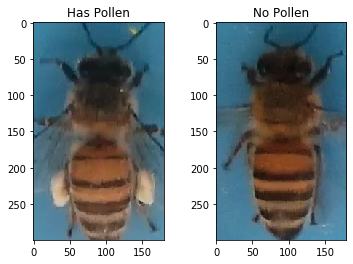

In [13]:
fig, axes = plt.subplots(1,2)
k=0
plt.sca(axes[0])
plt.imshow(X[k])
plt.title('Has Pollen'.format(k, Y[k]))

k=400
plt.sca(axes[1])
plt.imshow(X[k])
plt.title('No Pollen'.format(k, Y[k]));

*Goal*: Classify the bees that have pollen and those that do not.

## 1

Train a model from scratch using what little data you have without any regularization, to set a baseline for what can be achieved.

---

The first step in training the model is splitting the train and validation data.

In [28]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=18)

partial_x_train, validation_x_train, partial_y_train, validation_y_train = train_test_split(
    x_train, y_train, test_size=0.15, random_state=18)

With this, we can compile a model composed of the convolution layers. 

In [33]:
verbose = 0
# input
input_layer = Input(shape=(300, 180, 3))

# conv layers
conv_layer1   = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
conv_layer1   = MaxPool2D( (2, 2), padding='same')(conv_layer1)

conv_layer2   = Conv2D(64, (3, 3), activation='relu')(conv_layer1)
conv_layer2   = MaxPool2D( (2, 2), padding='same')(conv_layer2)

conv_layer3   = Conv2D(128, (3, 3), activation='relu')(conv_layer2)
conv_layer3   = Conv2D(128, (3, 3), activation='relu')(conv_layer3)
conv_layer3   = MaxPool2D( (2, 2), padding='same')(conv_layer3)

conv_layer4   = Conv2D(256, (3, 3), activation='relu')(conv_layer3)
conv_layer4   = Conv2D(256, (3, 3), activation='relu')(conv_layer4)
conv_layer4   = MaxPool2D( (2, 2), padding='same')(conv_layer4)

# flatten and dense layers
flatten_layer = Flatten()(conv_layer3)
dense_layer   = Dense(128, activation='relu')(flatten_layer)

# output
output_layer  = Dense(1, activation='sigmoid')(dense_layer)

model = Model(input_layer, output_layer)
model.compile(
    optimizer=RMSprop(lr=1e-4), 
    loss='binary_crossentropy',
    metrics=['accuracy'])
if verbose==1:
    print(model.summary())

In [ ]:
history = model.fit(
    partial_x_train, 
    partial_y_train,
    validation_data=(validation_x_train, validation_y_train),
    epochs=40, 
    batch_size=15, 
    verbose =1
)

Train on 485 samples, validate on 86 samples
Epoch 1/40
485/485 [==============================] - 76s 157ms/step - loss: 0.3208 - acc: 0.8701 - val_loss: 0.3409 - val_acc: 0.8721
Epoch 2/40
485/485 [==============================] - 77s 158ms/step - loss: 0.2633 - acc: 0.8784 - val_loss: 0.3337 - val_acc: 0.8721
Epoch 3/40
485/485 [==============================] - 78s 161ms/step - loss: 0.2485 - acc: 0.8907 - val_loss: 0.4034 - val_acc: 0.7907
Epoch 4/40
485/485 [==============================] - 79s 164ms/step - loss: 0.2169 - acc: 0.9175 - val_loss: 0.3023 - val_acc: 0.9186
Epoch 5/40
485/485 [==============================] - 81s 168ms/step - loss: 0.1950 - acc: 0.9196 - val_loss: 0.4813 - val_acc: 0.8140
Epoch 6/40
485/485 [==============================] - 86s 177ms/step - loss: 0.1821 - acc: 0.9299 - val_loss: 0.3542 - val_acc: 0.8953
Epoch 7/40
485/485 [==============================] - 78s 161ms/step - loss: 0.1589 - acc: 0.9361 - val_loss: 0.4707 - val_acc: 0.8256
Epoch 8/40